In [52]:
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

train_model = False  # 실제 훈련을 할 시 True 로 변경
device

'mps'

In [53]:
%%capture
# capture는 주렁주렁 출력 보여주지 않게끔
# Font 설치
!brew tap homebrew/cask-fonts
!brew install --cask font-nanum
!fc-cache -fv
!rm -rf ~/Library/Caches/matplotlib

In [54]:
import matplotlib.pyplot as plt

plt.rc("font", family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False

## 모델 구현

* encoder, decoder 의 self attention 을 수행하는 모듈

### einops
* 장점 : 텐서 변환을 매우 쉽게 이해하고 변환
* 단점 : 디버깅 힘들고 속도 느리다

In [55]:
from einops import rearrange

# 차원 재배치
x = torch.randn(2, 3, 4)
y = rearrange(x, "a b c -> c a b")  # 차원의 이름을 임의로 지정할 수 있다

y.shape

torch.Size([4, 2, 3])

In [56]:
# 차원 나누기
x = torch.randn(6, 4)
y = rearrange(
    x, "(a b) c -> a b c", a=2, b=3
)  # x 의 첫 번쨰 차원이 a 와 b 로 이루어져 있다

y.shape

torch.Size([2, 3, 4])

### Multi Head Attention (MHA) 구현

In [57]:
from torch import nn


class MHA(nn.Module):

    def __init__(self, d_model=512, n_heads=8):
        """
        d_model : dimension of embedding vector
        n_heads : num of heads in MHA
        """
        super().__init__()

        self.n_heads = n_heads

        # Q, K, V 벡터를 위한 linear layer
        self.fc_q = nn.Linear(in_features=d_model, out_features=d_model)
        self.fc_k = nn.Linear(in_features=d_model, out_features=d_model)
        self.fc_v = nn.Linear(in_features=d_model, out_features=d_model)

        # 최종 출력을 위한 linear layer
        self.fc_o = nn.Linear(in_features=d_model, out_features=d_model)

        # scaling for attention score
        self.scale = torch.sqrt(
            torch.tensor(d_model / n_heads)
        )  # GPU 에서의 연산을 위해 tensor 로 변환

    def forward(self, Q, K, V, mask=None):
        """
        Q, K, V : embedding vector of each word, (batch_size, max_len, dim)
        mask : mask for attention score (optional) => init as None
        """

        # linear transformation on embedding vector
        Q = self.fc_q(Q)
        K = self.fc_k(K)
        V = self.fc_v(V)

        # MHA 를 위해 embedding dim 을 n_head 개로 분할
        # ex. (32, 128, 512) -> (32, 8, 128, 64)
        Q = rearrange(Q, "N t (h dk) -> N h t dk", h=self.n_heads)
        K = rearrange(K, "N t (h dk) -> N h t dk", h=self.n_heads)
        V = rearrange(V, "N t (h dk) -> N h t dk", h=self.n_heads)

        # attention score before softmax
        attention_score = (
            Q @ K.transpose(-2, -1) / self.scale
        )  # (N, h, t, d_k) @ (N, h, d_k, t) -> (N, h, t(Query 길이), t(Key 길이))

        # masking on padding
        if mask is not None:
            attention_score[mask] = -1e10

        # softmax on Key
        energy = torch.softmax(attention_score, dim=-1)

        attention = energy @ V  # (N, h, t, t) @ (N, h, t, dk) -> (N, h, t, dk)

        # head 차원을 연결해서 원래의 차원으로 되돌리기
        x = rearrange(attention, "N h t dk -> N t (h dk)")  # (N, h, t, dk) -> (N, t, D)

        # 최종 출력값에 대해 linear transformation (모든 head 의 분석 결과를 종합)
        x = self.fc_o(x)

        return x, energy

### Feed Forward Network (FNN)
* encoder, decoder 의 MHA 결과를 하나로 합쳐준다

In [58]:
class FeedForward(nn.Module):
    def __init__(
        self, d_model=512, d_ff=2048, drop_p=0.1
    ):  # dropout : 차원 확장에 의한 overfitting 방지
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, mha_output):
        out = self.linear(mha_output)
        return out

## Encoder

In [59]:
# MHA - FFN 연결 과정, skip connection, LN
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        """
        d_model : 임베딩 벡터 차원
        d_ff : feed forward 은닉층 차원
        n_heads : MHA head 갯수
        drop_p : dropout 비율
        """
        super().__init__()

        # MHA (Self Attention)
        self.self_atten = MHA(d_model=d_model, n_heads=n_heads)

        # MHA 에 대한 layer normalization
        self.self_atten_LN = nn.LayerNorm(normalized_shape=d_model)

        # feed forward network
        self.FF = FeedForward(d_model=d_model, d_ff=d_ff, drop_p=drop_p)

        # feed forward 출력에 대한 LN
        self.FF_LN = nn.LayerNorm(normalized_shape=d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):
        """
        x : input tensor (batch_size, seq_len, d_model)
        enc_mask : input mask (batch_size, 1, seq_len)

        return : encoder output, energy
        """

        # MHA block
        residual, atten_enc = self.self_atten(Q=x, K=x, V=x, mask=enc_mask)
        residual = self.dropout(residual)

        # Skip Connection & LN
        encoder_self_attention_output = self.self_atten_LN(x + residual)

        # FFN block
        residual = self.FF(encoder_self_attention_output)
        residual = self.dropout(residual)

        # Skip Connection & LN
        encoder_ffn_output = self.FF_LN(encoder_self_attention_output + residual)

        return encoder_ffn_output, atten_enc

In [87]:
class Encoder(nn.Module):

    def __init__(
        self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p
    ):
        """
        input_embedding : 입력 임베딩 레이어 (nn.Embedding)
        max_len : input sequence 의 최대 길이 (int)
        n_layers : encoder layer 의 개수
        d_model : embedding vector 의 차원
        d_ff : feed forward의 은닉층의 차원
        n_heads : MHA의 head 개수
        drop_p : dropout 비율
        """

        super(Encoder, self).__init__()

        # d_model 의 제곱근 값으로 scale -> embedding vector 크기 조정
        self.scale = torch.sqrt(torch.tensor(d_model))

        # input embedding layer
        self.input_embedding = input_embedding

        # 위치 embedding layer : 위치 정보를 학습하기 위한 layer
        self.pos_embedding = nn.Embedding(num_embeddings=max_len, embedding_dim=d_model)

        self.dropout = nn.Dropout(drop_p)

        # 여러 개의 encoder layer 를 쌓기 위해 ModuleList 활용
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)]
        )

        self.device = device

    def forward(self, src, mask, atten_map_save=False):
        """
        src : input sequence (batch_size, seq_len)
        mask : mask for padding (batch_size, 1, seq_len)
        atten_map_save : attention map 을 저장할지 여부
        """
        # 위치 index tensor 생성 : 각 batch 에서 sequence 길이만큼 위치 index 반복
        pos = torch.arange(src.shape[1]).repeat(src.shape[0], 1).to(self.device)

        # input embedding 과 위치 embedding 을 합해 input tensor 생성
        x_embedding = self.input_embedding(src) + self.pos_embedding(pos)

        x_embedding = self.dropout(x_embedding)

        # 첫 입력
        encoder_output = x_embedding

        # energy 를 저장할 텐서
        atten_encs = torch.tensor([]).to(self.device)

        # 각 encoder layer 를 순차적으로 통과
        for layer in self.layers:
            encoder_output, atten_enc = layer(encoder_output, mask)

            if atten_map_save:
                atten_encs = torch.cat([atten_encs, atten_enc[0].unsqueeze()])

        return encoder_output, atten_encs

## Decoder
* masking 동작 실험

In [61]:
import torch

# 예제 설정
batch_size = 3
seq_len = 10
padding = 3
n_heads = 8

# attention_score 텐서 생성 (무작위 값으로 초기화)
# Shape: (batch_size, n_heads, seq_len, seq_len)
attention_score = torch.randn(batch_size, n_heads, seq_len, seq_len)

# enc_mask 생성: 패딩이 있는 위치를 마스킹
# 각 시퀀스의 마지막 3개 위치에 패딩이 있다고 가정합니다.
enc_mask = (
    torch.tensor(
        [
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],  # 첫 번째 시퀀스
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],  # 두 번째 시퀀스
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],  # 세 번째 시퀀스
        ],
        dtype=torch.bool,
    )
    .unsqueeze(1)
    .unsqueeze(2)
)  # Shape: (batch_size, 1, 1, seq_len)

# enc_mask의 shape을 (batch_size, n_heads, seq_len, seq_len)로 확장
enc_mask = enc_mask.expand(batch_size, n_heads, seq_len, seq_len)

print("=" * 20, "attention_score에 마스킹 적용 전", "=" * 20)
print("attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):\n", attention_score[0, 0])

# attention_score에 enc_mask 적용
if enc_mask is not None:
    attention_score[enc_mask] = (
        0  # 마스크된 위치에 매우 작은 값을 넣어 softmax 결과에 영향을 미치지 않도록 합니다.
    )

print("=" * 20, "attention_score에 마스킹 적용 전", "=" * 20)
print("attention_score shape:", attention_score.shape)
print(enc_mask.shape)

# 이제 attention_score 텐서에서 마스크가 적용된 부분을 확인할 수 있습니다.
# 특정 헤드에 대한 attention_score 확인 (예: 첫 번째 헤드)
print("=" * 20, "attention_score에 마스킹 적용 후", "=" * 20)
print("attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):\n", attention_score[0, 0])

==================== attention_score에 마스킹 적용 전 ====================
attention_score[0, 0] (첫 번째 배치, 첫 번째 헤드):
 tensor([[-0.5183, -2.0596,  0.6506, -1.5504,  0.3827, -0.7270,  1.2109, -0.6951,
         -0.5891, -0.2788],
        [-0.2571, -1.0110, -0.1957,  0.8078, -0.3465,  1.5329, -0.2836,  0.0332,
         -0.9639,  1.8615],
        [-0.8938,  1.2226, -2.6726,  0.2633,  2.5465, -1.2855, -0.7340, -0.8663,
          1.1198, -1.6744],
        [ 0.1153,  0.4407,  0.8844,  0.8611,  0.3045,  1.2003, -0.3898, -0.1153,
          0.7977,  1.1075],
        [-0.0661,  0.7321, -0.9453, -0.7476,  0.5816, -0.9432, -2.0681,  0.6070,
          1.0032, -0.3740],
        [ 0.5821, -0.5657,  0.6487,  0.5158, -0.2460,  0.1924, -0.8505,  1.8835,
         -1.7205, -1.1974],
        [ 0.1877, -0.4290,  0.7543,  0.8117,  0.4601, -0.2441, -0.4301,  0.6675,
         -0.8089, -1.3165],
        [ 0.5779,  0.2352,  0.7156,  0.9210, -1.8506,  0.3787,  1.4424, -0.7458,
         -1.3133,  0.6149],
        [-1.7010,

In [62]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        # self attention layer of decoder
        self.self_attn = MHA(d_model, n_heads)
        self.self_attn_LN = nn.LayerNorm(d_model)

        # Encoder - Decoder Attention layer
        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        # Feed Forward
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):
        """
        x : input tensor (batch_size, seq_len, d_model)
        enc_out : output tensor (batch_size, seq_len, d_model)
        dec_mask : mask for decoder self attention (batch_size, 1, seq_len)
        enc_dec_mask : mask for encoder-decoder attention (batch_size, 1, seq_len)

        return : output tensor, self attention map, encoder-decoder attention map
        """
        # decoder self attention
        residual, atten_dec = self.self_attn(Q=x, K=x, V=x, mask=dec_mask)
        residual = self.dropout(residual)
        decoder_masked_self_attention_output = self.self_attn_LN(x + residual)

        # encoder-decoder attention
        # Q : masked multi head attention
        # K, V : encoder output
        residual, atten_dec_enc = self.enc_dec_atten(
            Q=decoder_masked_self_attention_output,
            K=enc_out,
            V=enc_out,
            mask=enc_dec_mask,
        )

        residual = self.dropout(residual)
        decoder_masked_self_attention_output = self.enc_dec_atten_LN(x + residual)

        # feed forward
        residual = self.FF(decoder_masked_self_attention_output)
        residual = self.dropout(residual)
        decoder_output = self.FF_LN(decoder_masked_self_attention_output + residual)

        return decoder_output, atten_dec, atten_dec_enc

In [63]:
class Decoder(nn.Module):
    def __init__(
        self,
        input_embedding,
        max_len,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        drop_p,
        vocab_size,
    ):
        """
        input_embedding : 입력 임베딩 레이어 (nn.Embedding)
        max_len : input sequence 의 최대 길이 (int)
        n_layers : encoder layer 의 개수
        d_model : embedding vector 의 차원
        d_ff : feed forward의 은닉층의 차원
        n_heads : MHA의 head 개수
        drop_p : dropout 비율
        vocab_size : generator 를 만들기 위해 필요
        """
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))

        # input embedding layer
        self.input_embedding = input_embedding

        # position embedding layer
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # dropout
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)]
        )

        # Generator 구현
        # decoder output vector 를 단어의 확률 분포로 변환
        # decoder output vector 는 decoder layer 연산을 N 회 반복해 생성
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.device = device

    def forward(self, target, enc_out, dec_mask, enc_dec_mask, atten_map_save=False):
        # 위치 인덱스 텐서 생성: 각 배치에서 시퀀스 길이만큼 위치 인덱스를 반복
        pos = (
            torch.arange(target.shape[1]).repeat(target.shape[0], 1).to(self.device)
        )  # (batch_size, seq_len)

        # 입력 임베딩과 위치 임베딩을 합산하여 입력 텐서 x를 생성
        # 입력 임베딩에 scale을 곱해 크기를 조정
        y_embedding = self.scale * self.input_embedding(target) + self.pos_embedding(
            pos
        )  # (batch_size, seq_len, d_model)

        # 드롭아웃 적용
        y_embedding = self.dropout(y_embedding)

        # 어텐션 맵을 저장할 텐서 초기화 (빈 텐서로 시작)
        atten_decs = torch.tensor([]).to(self.device)
        atten_enc_decs = torch.tensor([]).to(self.device)

        # 제일 처음 입력은 y_embedding
        decoder_output = y_embedding

        # 각 decoder layer 통과
        for layer in self.layers:
            decoder_output, atten_dec, atten_enc_dec = layer(
                decoder_output, enc_out, dec_mask, enc_dec_mask
            )

            if atten_map_save:
                atten_decs = torch.cat([atten_decs, atten_dec[0].unsqueeze()])
                atten_enc_decs = torch.cat(
                    [atten_enc_decs, atten_enc_dec[0].unsqueeze()]
                )

        # Generator
        decoder_output_linear = self.fc_out(decoder_output)

        return decoder_output_linear, atten_decs, atten_enc_decs

## Transfomer

* encoder, decoder 조립
* encoder, decoder mask 생성

In [80]:
class Transformer(nn.Module):

    def __init__(
        self,
        vocab_size,
        max_len,
        n_layers,
        pad_idx,
        d_model=512,
        d_ff=2048,
        n_heads=8,
        drop_p=0.1,
    ):
        super().__init__()

        # 입력 임베딩 레이어 정의
        self.input_embedding = nn.Embedding(vocab_size, d_model)

        # 인코더, 디코더
        self.encoder = Encoder(
            self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p
        )
        self.decoder = Decoder(
            self.input_embedding,
            max_len,
            n_layers,
            d_model,
            d_ff,
            n_heads,
            drop_p,
            vocab_size,
        )

        # 멀티 헤드 어텐션 헤드 개수
        self.n_heads = n_heads

        # 모든 모듈의 가중치를 Xavier 초기값으로 설정. 단, Layer Normalization이 가중치 제외.
        for m in self.modules():
            if (
                hasattr(m, "weight") and m.weight.dim() > 1
            ):  # 인풋 임베딩은 그대로 사용하기 위함
                nn.init.xavier_uniform_(
                    m.weight
                )  # Xavier 초기화를 사용하여 가중치를 초기화

        # 패딩 토큰 인덱스
        self.pad_idx = pad_idx

    def make_enc_mask(self, src):
        """
        인코더 마스크 생성
        src : 입력 시퀀스, Shape: (batch_size, seq_len)
        return : 인코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
        """

        # 패딩 위치에 대해 True 값을 가지는 마스크 생성
        enc_mask = (
            (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        )  # Shape: (batch_size, 1, 1, seq_len)

        # 헤드 수만큼 마스크를 반복하여 확장
        enc_mask = enc_mask.repeat(
            1, self.n_heads, src.shape[1], 1
        )  # Shape: (batch_size, n_heads, seq_len, seq_len)

        """
    예시:
    F F T T
    F F T T
    F F T T
    F F T T
    """
        return enc_mask

    def make_dec_mask(self, trg):
        """
        디코더 마스크 생성
        trg : 목표 시퀀스, Shape: (batch_size, seq_len)
        return : 디코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
        """

        # 패딩 위치에 대해 True 값을 가지는 마스크 생성
        trg_pad_mask = (
            (trg.to("cpu") == self.pad_idx).unsqueeze(1).unsqueeze(2)
        )  # Shape: (batch_size, 1, 1, seq_len)

        # 헤드 수만큼 마스크를 반복하여 확장
        trg_pad_mask = trg_pad_mask.repeat(
            1, self.n_heads, trg.shape[1], 1
        )  # Shape: (batch_size, n_heads, seq_len, seq_len)

        """
    예시:
    F F F T T
    F F F T T
    F F F T T
    F F F T T
    F F F T T
    """

        # 현재 시점 이후의 위치에 대해 마스크 생성 (미래의 토큰을 마스킹)
        trg_future_mask = (
            torch.tril(
                torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])
            )
            == 0
        )  # Shape: (batch_size, n_heads, seq_len, seq_len)

        """
    예시:
    F T T T T
    F F T T T
    F F F T T
    F F F F T
    F F F F F
    """

        # 패딩 마스크와 미래 마스크를 결합하여 최종 디코더 마스크 생성
        dec_mask = (
            trg_pad_mask | trg_future_mask
        )  # Shape: (batch_size, n_heads, seq_len, seq_len)

        """
    예시:
    F T T T T
    F F T T T
    F F F T T
    F F F F T
    F F F F F
    """
        return dec_mask

    def make_enc_dec_mask(self, src, trg):
        """
        인코더-디코더 마스크 생성
        src : 입력 시퀀스, Shape: (batch_size, seq_len)
        trg : 목표 시퀀스, Shape: (batch_size, seq_len)
        return : 인코더-디코더 마스크, Shape: (batch_size, n_heads, seq_len, seq_len)
        """

        # 패딩 위치에 대해 True 값을 가지는 마스크 생성 (인코더와 디코더 사이의 어텐션에 사용)
        enc_dec_mask = (
            (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        )  # Shape: (batch_size, 1, 1, seq_len)

        # 헤드 수만큼 마스크를 반복하여 확장
        enc_dec_mask = enc_dec_mask.repeat(
            1, self.n_heads, trg.shape[1], 1
        )  # Shape: (batch_size, n_heads, trg_seq_len, src_seq_len)

        """
    예시:
    F F T T
    F F T T
    F F T T
    F F T T
    F F T T
    """
        return enc_dec_mask

    def forward(self, src, trg):
        """
        src : 입력 시퀀스, Shape: (batch_size, seq_len)
        trg : 목표 시퀀스, Shape: (batch_size, seq_len)
        return : 모델 출력, 인코더 어텐션 맵, 디코더 어텐션 맵, 인코더-디코더 어텐션 맵
        """

        # 인코더 마스크 생성
        enc_mask = self.make_enc_mask(src)

        # 디코더 마스크 생성
        dec_mask = self.make_dec_mask(trg)

        # 인코더-디코더 마스크 생성
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        # 인코더 통과
        enc_out, atten_encs = self.encoder(src, enc_mask)

        # 디코더 통과
        out, atten_decs, atten_enc_decs = self.decoder(
            trg, enc_out, dec_mask, enc_dec_mask
        )

        return out, atten_encs, atten_decs, atten_enc_decs

In [65]:
import pandas as pd

df = pd.read_excel("../../data/nlp/kor_eng_translate.xlsx")
df.head()

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


In [66]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)


train_data.shape, valid_data.shape, test_data.shape

((64000, 7), (16000, 7), (20000, 7))

In [67]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return (
            self.data.iloc[idx, self.data.columns.get_loc("원문")],
            self.data.iloc[idx, self.data.columns.get_loc("번역문")],
        )


train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

train_dataset[0]

('음료수는 콜라, 사이다 중에 어떤 걸로 하시겠어요?',
 'Which drink would you like out of coke and soda?')

In [68]:
BATCH_SIZE = 32

train_DL = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_DL = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False
)
test_DL = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [69]:
from transformers import MarianMTModel, MarianTokenizer  # MT: Machine Translation

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ko-en")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-ko-en")

In [70]:
# 사전학습된 (pretrained) 모델의 성능을 알아보자
max_len = 128  # 기본은 512인데, 너무 길면 gpu에 부담됨 ㅎㅎ;

input_text = "김탱구"

# tokenizer.encode : 텍스트 -> 단어 토큰화-> 정수로 바꿔줌.
src_tokens = tokenizer.encode(input_text, return_tensors="pt")
src_tokens

tensor([[15004, 37141,   603,     0]])

In [71]:
translated_tokens = model.generate(src_tokens, max_new_tokens=max_len)
translated_tokens

tensor([[65000, 16456,  1220,  8199, 13936,     0]])

In [72]:
# 정수를 텍스트로 바꾸는걸 뭐라고 해찌? decode
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
translated_text

'Kim Tang Gu'

In [73]:
# src에는 한국어(원문), trg에는 영어(번역)
src_texts, trg_texts = next(iter(train_DL))
print(src_texts[0], " ==> ", trg_texts[0])
print(src_texts[1], " ==> ", trg_texts[1])
print(src_texts[2], " ==> ", trg_texts[2])

이번 주말은 바쁘고, 다음다음 주 주말 어때?  ==>  This weekend I am busy, so how about next next weekend?
죄송한 건 됐고 이거 어떻게 하실 건지 물었잖아요?  ==>  That is enough apologies, I asked what you will do about this?
근데, 아무리 봐도 이 주변에는 주택 밖에 안 보이는데.  ==>  But, I can only see houses around here.


In [74]:
src_tokens = tokenizer.tokenize(src_texts[0])
trg_tokens = tokenizer.tokenize(trg_texts[0])

print(src_tokens)
print(trg_tokens)

['▁이번', '▁주말', '은', '▁바쁘', '고', ',', '▁다음', '다음', '▁주', '▁주말', '▁어때', '?']
['▁', 'Th', 'is', '▁w', 'eek', 'end', '▁I', '▁', 'am', '▁b', 'us', 'y', ',', '▁so', '▁h', 'ow', '▁about', '▁n', 'ext', '▁n', 'ext', '▁w', 'eek', 'end', '?']


## 모델 생성 및 hyperparameter 설정

In [81]:
vocab_size = tokenizer.vocab_size  # 인코더, 디코더에서 사용할 단어의 총 개수
n_layers = 3  # 원래 논문에서는 6개
d_model = 256  # 원래 논문에서는 512
d_ff = 512  # 원래 논문에서는 2048
n_heads = 8
drop_p = 0.1

In [82]:
pad_idx = tokenizer.pad_token_id
pad_idx

65000

In [83]:
# 문장의 최대 길이
max_len = 128

In [88]:
model = Transformer(
    vocab_size, max_len, n_layers, pad_idx, d_model, d_ff, n_heads, drop_p
)

model

Transformer(
  (input_embedding): Embedding(65001, 256)
  (encoder): Encoder(
    (input_embedding): Embedding(65001, 256)
    (pos_embedding): Embedding(128, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_atten): MHA(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_atten_LN): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (FF): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=256, out_features=512, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
        (FF_LN): LayerNorm((256,), eps=1e-

In [90]:
from tqdm import tqdm
import math

EPOCH = 15
save_model_path = "../../data/saved_models/NLP/transformer_model.pt"
save_history_path = "../../data/saved_models/NLP/transformer_history.pt"

In [91]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler=None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train()  # train mode로 전환
        train_loss = loss_epoch(
            model, train_DL, criterion, optimizer=optimizer, scheduler=scheduler
        )
        loss_history["train"] += [train_loss]

        model.eval()  # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(
                    {
                        "model": model,
                        "ep": ep,
                        "optimizer": optimizer,
                        "scheduler": scheduler,
                    },
                    save_model_path,
                )
        # print loss
        print(
            f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}"
        )
        print("-" * 20)

    torch.save(
        {"loss_history": loss_history, "EPOCH": EPOCH, "BATCH_SIZE": BATCH_SIZE},
        save_history_path,
    )


def Test(model, test_DL, criterion):
    model.eval()  # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")


def loss_epoch(model, DL, criterion, optimizer=None, scheduler=None):
    N = len(DL.dataset)  # the number of data

    rloss = 0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(
            src_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        ).input_ids.to(device)
        trg_texts = ["</s> " + s for s in trg_texts]
        trg = tokenizer(
            trg_texts,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        ).input_ids.to(device)
        # inference
        y_hat = model(src, trg[:, :-1])[
            0
        ]  # 모델 통과 시킬 땐 trg의 마지막 토큰은 제외!
        # y_hat.shape = 개단차 즉, 훈련 땐 문장이 한번에 튀어나옴
        # loss
        loss = criterion(
            y_hat.permute(0, 2, 1), trg[:, 1:]
        )  # loss 계산 시엔 <sos> 는 제외!
        # (개단차) -> 개차단으로 바꿔줌 (1D segmentation으로 생각)
        # 개채행열(예측), 개행열(정답)으로 주거나 개채1열, 개1열로 주거나 개채열, 개열로 줘야하도록 함수를 만들어놔서
        # 우리 상황에서는 개차단, 개단 으로 줘야 한다.
        # 이렇게 함수를 만들어놔야 1D, 2D segmentation 등등으로 확장가능하기 때문
        # 다 필요없고, 그냥 y_hat=개차단, trg=개단으로 줘야만 계산 제대로 된다고 생각하시면 됩니다!
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss / N
    return loss_e


def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num


class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale=1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = (
            self.LR_scale
            * (self.d_model**-0.5)
            * min(self.current_step**-0.5, self.current_step * self.warmup_steps**-1.5)
        )
        self.optimizer.param_groups[0]["lr"] = lrate


def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps):  # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for (
        _
    ) in (
        steps
    ):  # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했다고 함
        lr_history += [optimizer.param_groups[0]["lr"]]
        scheduler.step()

    plt.figure()
    if scheduler_name == "Noam":
        if total_steps == 100000:
            plt.plot(
                steps,
                (512**-0.5) * torch.tensor(steps) ** -0.5,
                "g--",
                linewidth=1,
                label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$",
            )
            plt.plot(
                steps,
                (512**-0.5) * torch.tensor(steps) * 4000**-1.5,
                "r--",
                linewidth=1,
                label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$",
            )
        plt.plot(steps, lr_history, "b", linewidth=2, alpha=0.8, label="Learning Rate")
    elif scheduler_name == "Cos":
        plt.plot(steps, lr_history, "b", linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1 * max(lr_history), 1.2 * max(lr_history)])
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.show()

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarun

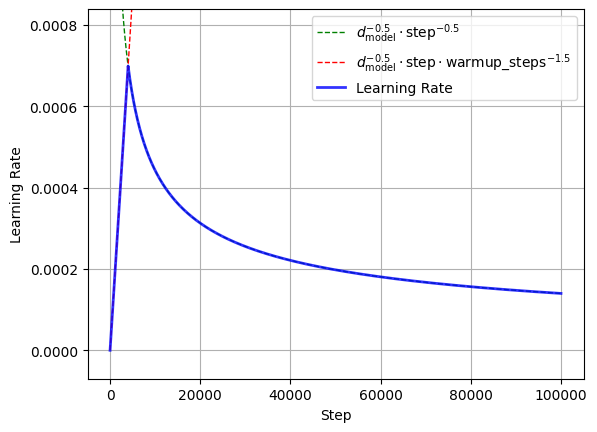

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

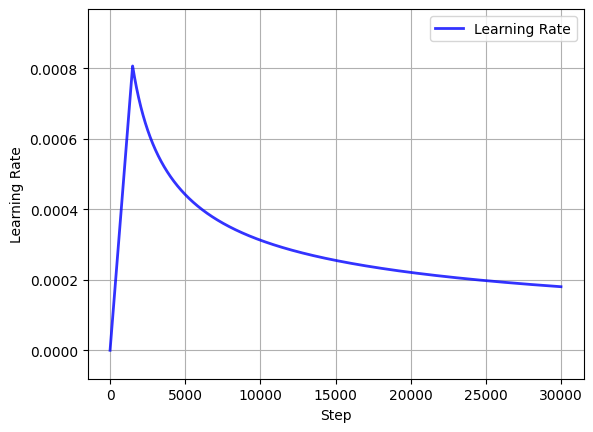

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

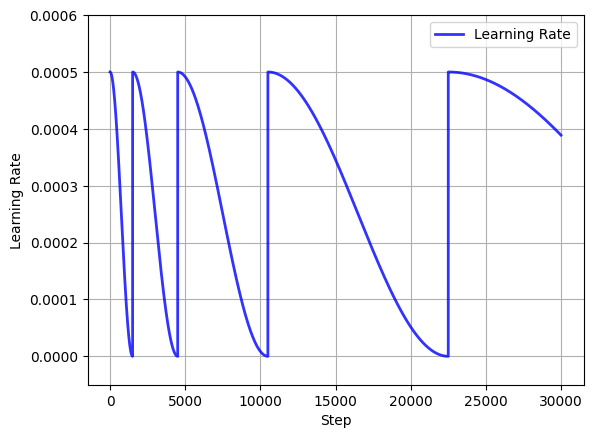

In [92]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss(
    ignore_index=pad_idx
)  # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시) # 저장된 모델
# criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, label_smoothing = 0.1) # 막상 해보니 성능 안나옴 <- 데이터가 많아야 할 듯

scheduler_name = "Noam"
# scheduler_name = 'Cos'
#### Noam ####
# warmup_steps = 4000 # 이건 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1500  # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 # 저장된 모델
LR_scale = 0.5  # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석 # 저장된 모델
#### Cos ####
LR_init = 5e-4
T0 = 1500  # 첫 주기
T_mult = 2  # 배 만큼 주기가 길어짐 (1보다 큰 정수여야 함)
#############


optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)  # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000)  # 논문 값
plot_scheduler(
    scheduler_name="Noam", optimizer=optimizer, scheduler=scheduler, total_steps=100000
)

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(
    optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale
)
plot_scheduler(
    scheduler_name="Noam",
    optimizer=optimizer,
    scheduler=scheduler,
    total_steps=int(len(train_dataset) * EPOCH / BATCH_SIZE),
)  # 내 상황

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=LR_init)
scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)
plot_scheduler(
    scheduler_name="Cos",
    optimizer=optimizer,
    scheduler=scheduler,
    total_steps=int(len(train_dataset) * EPOCH / BATCH_SIZE),
)